In [ ]:
# IMPORT LIBRARIES

# Core libraries
import gdown, pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

# ML libraries
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    average_precision_score, precision_recall_curve,
    mean_absolute_error, mean_squared_error, r2_score
)

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define base directory and subfolders
base_path = "/content/drive/MyDrive/IE434 - Energy Prices in Illinois (Deep Dive 2)"
raw_path = f"{base_path}/Data Extraction/raw"
debug_path = f"{base_path}/Data Extraction/debug"
working_path = f"{base_path}/Data Extraction/working"
processed_path = f"{base_path}/Data Extraction/processed"

#### **Actual LMP Data**

Load the MISO datasets (Actual, Day-Ahead, and Load). Each file is standardized for consistent column names, converted to proper datatypes, sorted chronologically, and split into debug and working subsets for analysis.

In [ ]:
# Import MISO_Actual_Energy_Price data

def to_dt(series):
    return pd.to_datetime(series, format="%m/%d/%Y %I:%M:%S %p", errors="coerce")

actual = pd.read_csv(f"{raw_path}/MISO_Actual_Energy_Price.csv", low_memory=False)
actual = actual.rename(columns={"Date": "Timestamp", "LMP": "lmp", "HUB": "hub"})

# convert to datetime + dtypes
actual["Timestamp"] = to_dt(actual["Timestamp"])
actual["lmp"] = pd.to_numeric(actual["lmp"], errors="coerce").astype("float32")
actual["hub"] = actual["hub"].astype("category")
actual = actual.dropna(subset=["Timestamp"]).sort_values("Timestamp")
actual = actual.set_index("Timestamp")[["lmp", "hub"]]

# debug and working splits
debug_actual = actual.iloc[:5000]
working_actual = actual.loc["2017-08-23":"2025-01-31"]

debug_actual.to_pickle(f"{debug_path}/actual_lmp_il_debug.pkl")
debug_actual.to_csv(f"{debug_path}/actual_lmp_il_debug.csv")
working_actual.to_pickle(f"{working_path}/actual_lmp_il_working.pkl")
working_actual.to_csv(f"{working_path}/actual_lmp_il_working.csv")

print("Actual LMP ", debug_actual.shape, working_actual.shape)
actual.head()


Actual LMP  (5000, 2) (372240, 2)


,lmp,hub
Timestamp,,
2006-04-10 11:00:00,68.839996,CINERGY.HUB
2006-04-10 11:00:00,70.070000,FE.HUB
2006-04-10 11:00:00,68.040001,ILLINOIS.HUB
2006-04-10 11:00:00,73.330002,MICHIGAN.HUB
2006-04-10 11:00:00,63.430000,MINN.HUB


#### **Day-Ahead LMP Data**

Same structure as Actual LMP; ensures temporal consistency and unified naming.

In [ ]:
# Import MISO_Day_Ahead_Energy_Price data

dayahead = pd.read_csv(f"{raw_path}/MISO_Day_Ahead_Energy_Price.csv", low_memory=False)
dayahead = dayahead.rename(columns={"Date": "Timestamp", "lmp": "lmp", "node": "hub"})

# convert to datetime + dtypes
dayahead["Timestamp"] = to_dt(dayahead["Timestamp"])
dayahead["lmp"] = pd.to_numeric(dayahead["lmp"], errors="coerce").astype("float32")
dayahead["hub"] = dayahead["hub"].astype("category")
dayahead = dayahead.dropna(subset=["Timestamp"]).sort_values("Timestamp")
dayahead = dayahead.set_index("Timestamp")[["lmp", "hub"]]

# debug and working splits
debug_dayahead = dayahead.iloc[:5000]
working_dayahead = dayahead.loc["2017-08-23":"2025-12-31"]

debug_dayahead.to_pickle(f"{debug_path}/dayahead_lmp_il_debug.pkl")
debug_dayahead.to_csv(f"{debug_path}/dayahead_lmp_il_debug.csv")
working_dayahead.to_pickle(f"{working_path}/dayahead_lmp_il_working.pkl")
working_dayahead.to_csv(f"{working_path}/dayahead_lmp_il_working.csv")

print("Day-Ahead LMP ", debug_dayahead.shape, working_dayahead.shape)
dayahead.head()

Day-Ahead LMP  (5000, 2) (564768, 2)


,lmp,hub
Timestamp,,
2014-01-01,34.430000,ARKANSAS.HUB
2014-01-01,26.629999,ILLINOIS.HUB
2014-01-01,27.780001,INDIANA.HUB
2014-01-01,32.279999,LOUISIANA.HUB
2014-01-01,28.690001,MICHIGAN.HUB


#### **Load Data**

Import forecasted, cleared, and actual load series. Convert numeric columns and align timestamps.

In [ ]:
# Import MISO_Forecasted_Cleared_Actual_Load data

load = pd.read_csv(f"{raw_path}/MISO_Forecasted_Cleared_Actual_Load.csv", low_memory=False)
load = load.rename(columns={"DATE": "Timestamp"})
load = load[["Timestamp", "ForecastedLoad", "ClearedLoad", "ActualLoad"]]

# convert to datetime + dtypes
load["Timestamp"] = to_dt(load["Timestamp"])
for c in ["ForecastedLoad", "ClearedLoad", "ActualLoad"]:
    load[c] = pd.to_numeric(load[c], errors="coerce").astype("float32")
load = load.dropna(subset=["Timestamp"]).sort_values("Timestamp")
load = load.set_index("Timestamp")

# debug and working splits
debug_load = load.iloc[:5000]
working_load = load.loc["2017-08-23":"2025-12-31"]

debug_load.to_pickle(f"{debug_path}/miso_load_debug.pkl")
debug_load.to_csv(f"{debug_path}/miso_load_debug.csv")
working_load.to_pickle(f"{working_path}/miso_load_working.pkl")
working_load.to_csv(f"{working_path}/miso_load_working.csv")

print("Load ", debug_load.shape, working_load.shape)

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 160)

# Paths (adjust if your location changes)
ACT_PATH = f"{working_path}/actual_lmp_il_working.csv"
DA_PATH  = f"{working_path}/dayahead_lmp_il_working.csv"
LOAD_PATH = f"{working_path}/miso_load_working.csv"
load.head()

Load  (5000, 3) (60182, 3)


,ForecastedLoad,ClearedLoad,ActualLoad
Timestamp,,,
2017-08-23 01:00:00,71745.0,65693.0,67376.0
2017-08-23 02:00:00,68985.0,63414.0,65109.0
2017-08-23 03:00:00,67338.0,62239.0,64196.0
2017-08-23 04:00:00,66788.0,61849.0,63973.0
2017-08-23 05:00:00,67886.0,63837.0,66204.0


In [ ]:
# Display all columns clearly when printing dataframes
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 160)

# === Load Working Datasets ===
# Paths (adjust if your location changes)
ACT_PATH = f"{working_path}/actual_lmp_il_working.csv"
DA_PATH  = f"{working_path}/dayahead_lmp_il_working.csv"
LOAD_PATH = f"{working_path}/miso_load_working.csv"

# Load and ensure datetime index
actual = pd.read_csv(ACT_PATH, parse_dates=["Timestamp"]).set_index("Timestamp")
dayahead = pd.read_csv(DA_PATH, parse_dates=["Timestamp"]).set_index("Timestamp")
load = pd.read_csv(LOAD_PATH, parse_dates=["Timestamp"]).set_index("Timestamp")

# Force index to datetime
actual.index = pd.to_datetime(actual.index, errors="coerce")
dayahead.index = pd.to_datetime(dayahead.index, errors="coerce")
load.index = pd.to_datetime(load.index, errors="coerce")

### **Milestone 2 — Data Exploration**  

**Goal:** Understand the dataset’s coverage, distributions, potential label bias, and common data issues (missingness, imbalance, sparsity).  

**Process:**  
1. Load pre-processed working datasets (**Actual**, **Day-Ahead**, and **Load**).  
2. Normalize column names for consistency.  
3. Set the timestamp as the index to prepare for time-series merging.  
4. Inspect shapes, time coverage, and unique hubs.  

**Outputs:**  
Basic information on dataset dimensions, date ranges, and initial data preview.

In [ ]:
# === Data Exploration — Initial Loading and Inspection ===

# Load with datetime parsing
actual = pd.read_csv(ACT_PATH, parse_dates=["Timestamp"])
dayahead = pd.read_csv(DA_PATH, parse_dates=["Timestamp"])
load = pd.read_csv(LOAD_PATH, parse_dates=["Timestamp"])

# Normalize column names to ensure consistency across datasets
actual = actual.rename(columns={"Date": "Timestamp", "LMP": "lmp", "HUB": "hub"})
dayahead = dayahead.rename(columns={"Date": "Timestamp", "LMP": "lmp", "HUB": "hub"})
load = load.rename(columns={"Date": "Timestamp"})

# Set 'Timestamp' as datetime index for all datasets
actual = actual.set_index("Timestamp")
dayahead = dayahead.set_index("Timestamp")
load = load.set_index("Timestamp")

# Display basic metadata
print("Actual price:", actual.shape, "date range:", actual.index.min(), "->", actual.index.max(), "unique hubs:", actual["hub"].nunique())
print("Day-ahead  :", dayahead.shape, "date range:", dayahead.index.min(), "->", dayahead.index.max(), "unique hubs:", dayahead["hub"].nunique())
print("Load       :", load.shape, "date range:", load.index.min(), "->", load.index.max())

print("\nSample rows:")
display(actual.head(3))
display(dayahead.head(3))
display(load.head(3))


Actual price: (372240, 2) date range: 2017-08-24 00:00:00 -> 2025-01-31 22:00:00 unique hubs: 8
Day-ahead  : (564768, 2) date range: 2017-08-23 00:00:00 -> 2025-09-24 23:00:00 unique hubs: 8
Load       : (60182, 3) date range: 2017-08-23 01:00:00 -> 2025-02-06 00:00:00

Sample rows:


,lmp,hub
Timestamp,,
2017-08-24,18.76,ARKANSAS.HUB
2017-08-24,19.31,ILLINOIS.HUB
2017-08-24,20.09,INDIANA.HUB


,lmp,hub
Timestamp,,
2017-08-23,19.45,ARKANSAS.HUB
2017-08-23,18.74,ILLINOIS.HUB
2017-08-23,20.95,INDIANA.HUB


,ForecastedLoad,ClearedLoad,ActualLoad
Timestamp,,,
2017-08-23 01:00:00,71745.0,65693.0,67376.0
2017-08-23 02:00:00,68985.0,63414.0,65109.0
2017-08-23 03:00:00,67338.0,62239.0,64196.0


### **Data Consistency & Coverage Check**

We ensure that all datasets (Actual, Day-Ahead, and Load) are **chronologically sorted** and their timestamps are properly parsed as datetime objects.  
Next, we perform a **missingness and coverage check** to confirm that all three data sources align in time and that there are no critical data gaps before merging.  

**Goal:** Verify clean datetime indices, detect missing values, and confirm consistent coverage windows.  
**Output:** Missing value summary and date ranges for each dataset.

In [ ]:
# === Data Consistency & Coverage Check ===

# Sort each dataset chronologically to ensure proper time alignment
actual   = actual.sort_index()
dayahead = dayahead.sort_index()
load     = load.sort_index()

# Ensure indices are valid datetime objects (safety check)
actual.index   = pd.to_datetime(actual.index, errors="coerce")
dayahead.index = pd.to_datetime(dayahead.index, errors="coerce")
load.index     = pd.to_datetime(load.index, errors="coerce")

# Summarize missing values across datasets
print("Missing values summary:")
print("\nActual LMP:\n", actual.isna().sum())
print("\nDay-Ahead LMP:\n", dayahead.isna().sum())
print("\nLoad Data:\n", load.isna().sum())

# Show time coverage for each dataset
print("\nCoverage windows:")
print("Actual    :", actual.index.min(),   "→", actual.index.max())
print("Day-Ahead :", dayahead.index.min(), "→", dayahead.index.max())
print("Load      :", load.index.min(),     "→", load.index.max())

Missing values summary:

Actual LMP:
 lmp    0
hub    0
dtype: int64

Day-Ahead LMP:
 lmp    0
hub    0
dtype: int64

Load Data:
 ForecastedLoad      0
ClearedLoad         0
ActualLoad        579
dtype: int64

Coverage windows:
Actual    : 2017-08-24 00:00:00 → 2025-01-31 22:00:00
Day-Ahead : 2017-08-23 00:00:00 → 2025-09-24 23:00:00
Load      : 2017-08-23 01:00:00 → 2025-02-06 00:00:00


### **Missingness & Time Windows**

We confirm the **common time range** shared across Actual, Day-Ahead, and Load datasets and visualize recent trends.  
This step helps verify temporal overlap and detect any structural gaps before merging.  

**Process:**  
1. Compute common start and end timestamps across all datasets.  
2. Extract the most recent 365-day window for visual inspection.  
3. Plot Actual, Day-Ahead, and Load series to confirm continuity and data health.  

**Goal:** Ensure all datasets share the same temporal window for later alignment and modeling.  
**Output:** Common date range, recent-year visualizations, and confirmation of no major missing segments.


Common window: 2017-08-24 00:00:00 -> 2025-01-31 22:00:00
Recent window: 2024-02-01 22:00:00 -> 2025-01-31 22:00:00


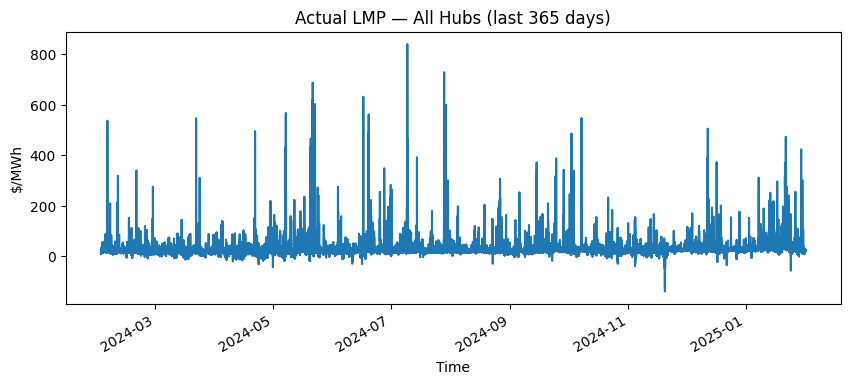

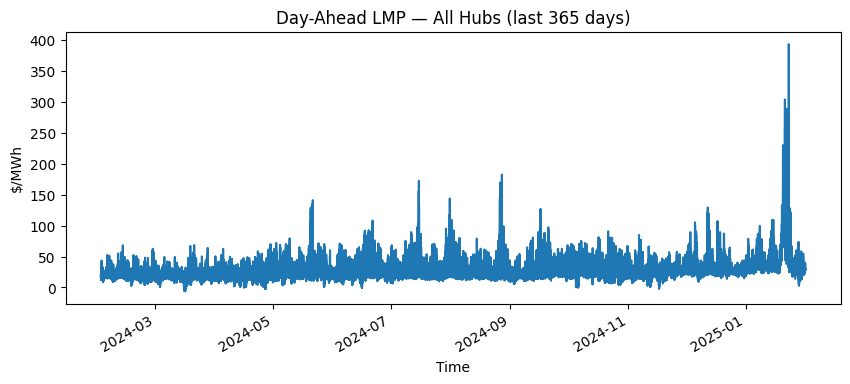

<Figure size 1000x400 with 0 Axes>

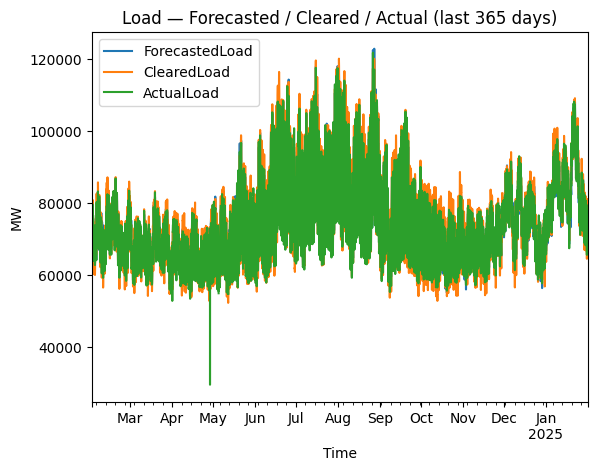

In [ ]:
# === Missingness & Time Windows ===

# Determine common date window and then take last 365 days
start_common = max(actual.index.min(), dayahead.index.min(), load.index.min())
end_common = min(actual.index.max(), dayahead.index.max(), load.index.max())

recent_end = end_common
recent_start = max(start_common, recent_end - pd.Timedelta(days=365))

print("Common window:", start_common, "->", end_common)
print("Recent window:", recent_start, "->", recent_end)

# Slice last 365 days for each dataset
actual_recent = actual.loc[recent_start:recent_end]
dayahead_recent = dayahead.loc[recent_start:recent_end]
load_recent = load.loc[recent_start:recent_end]

# === Simple time series plots ===
plt.figure(figsize=(10,4))
actual_recent["lmp"].plot()
plt.title("Actual LMP — All Hubs (last 365 days)")
plt.xlabel("Time")
plt.ylabel("$/MWh")
plt.show()

plt.figure(figsize=(10,4))
dayahead_recent["lmp"].plot()
plt.title("Day-Ahead LMP — All Hubs (last 365 days)")
plt.xlabel("Time")
plt.ylabel("$/MWh")
plt.show()

plt.figure(figsize=(10,4))
load_recent[["ForecastedLoad", "ClearedLoad", "ActualLoad"]].plot()
plt.title("Load — Forecasted / Cleared / Actual (last 365 days)")
plt.xlabel("Time")
plt.ylabel("MW")
plt.show()

### **Time-Series Overview (Last 365 Days)**

We summarize **price and load dynamics** over the most recent year to understand variability, diurnal structure, and volatility.  
These visualizations highlight how LMPs fluctuate across hours and days, showing daily market patterns and occasional spikes caused by demand surges or grid events.  

**Process:**  
1. Compute descriptive statistics for Actual and Day-Ahead LMP.  
2. Plot histograms to inspect price distribution and skewness.  
3. Add time-of-day (`hour`) and day-of-week (`dow`) features to explore periodic behavior.  
4. Visualize grouped boxplots to reveal hourly and weekly variation patterns.  

**Goal:** Detect recurring temporal structures and anomalies in LMP data.  
**Output:** Summary statistics, histograms, and hourly/weekly boxplots.


Actual LMP stats (full hub):


,lmp
count,372240.000000
mean,34.965936
std,41.226794
min,-186.870000
10%,17.250000
25%,21.090000
50%,25.850000
75%,37.480000
90%,59.930000
95%,80.630000



Day-Ahead LMP stats (full hub):


,lmp
count,564768.000000
mean,33.841447
std,23.964873
min,-54.470000
10%,17.850000
25%,21.650000
50%,27.290000
75%,38.430000
90%,56.460000
95%,72.336500


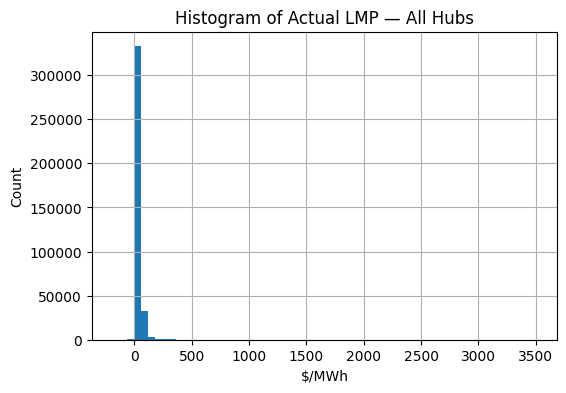

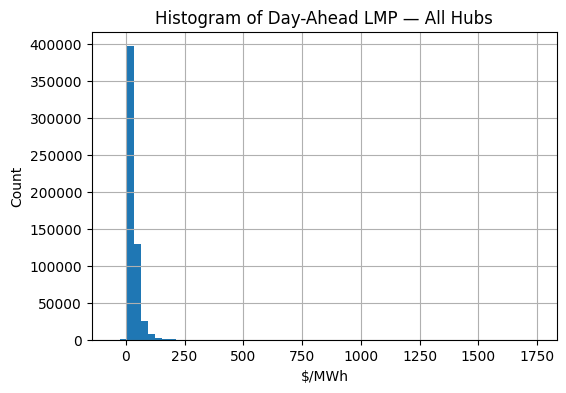

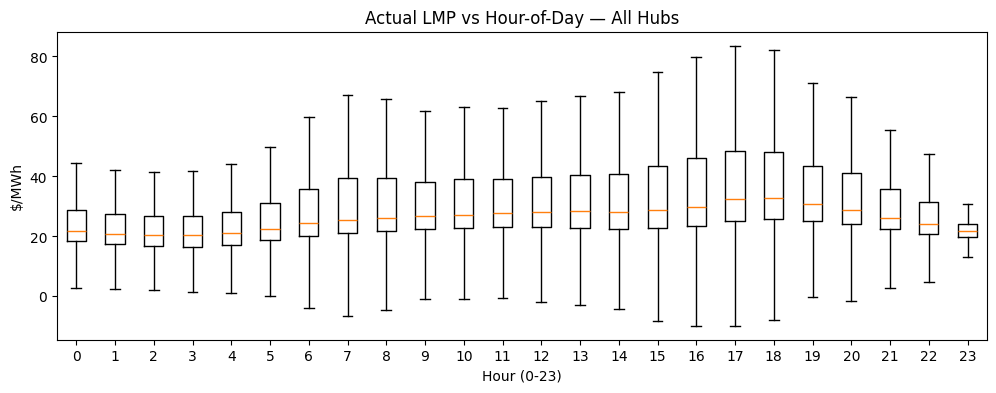

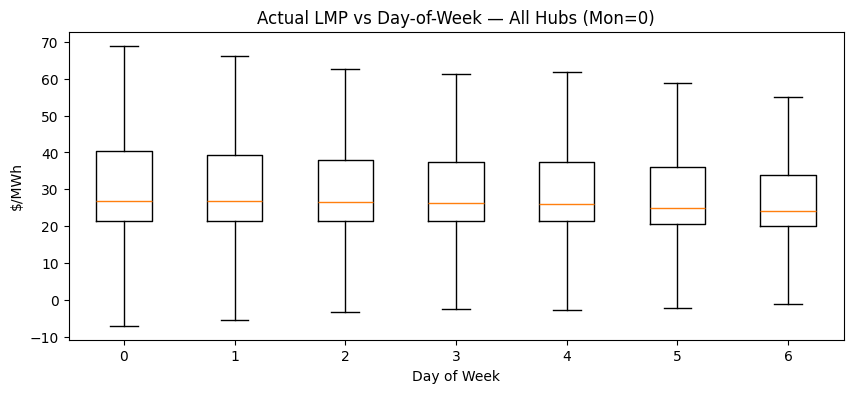

In [ ]:
# === Time-Series Overview (Last 365 Days) ===

# Descriptive stats
print("Actual LMP stats (full hub):")
display(actual['lmp'].describe(percentiles=[0.1,0.25,0.5,0.75,0.9,0.95,0.99]))
print("\nDay-Ahead LMP stats (full hub):")
display(dayahead['lmp'].describe(percentiles=[0.1,0.25,0.5,0.75,0.9,0.95,0.99]))

# Histograms
plt.figure(figsize=(6,4))
actual['lmp'].dropna().hist(bins=60)
plt.title("Histogram of Actual LMP — All Hubs")
plt.xlabel("$/MWh")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(6,4))
dayahead['lmp'].dropna().hist(bins=60)
plt.title("Histogram of Day-Ahead LMP — All Hubs")
plt.xlabel("$/MWh")
plt.ylabel("Count")
plt.show()

# Hour-of-day / Day-of-week patterns
def add_time_parts(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dow'] = df.index.dayofweek  # Monday=0
    return df

act_tp = add_time_parts(actual)
da_tp  = add_time_parts(dayahead)

# Box-like plots using matplotlib (grouped)
hour_groups = [act_tp.loc[act_tp['hour']==h, 'lmp'].dropna().values for h in range(24)]
plt.figure(figsize=(12,4))
plt.boxplot(hour_groups, positions=list(range(24)), showfliers=False)
plt.title("Actual LMP vs Hour-of-Day — All Hubs")
plt.xlabel("Hour (0-23)")
plt.ylabel("$/MWh")
plt.show()

dow_groups = [act_tp.loc[act_tp['dow']==d, 'lmp'].dropna().values for d in range(7)]
plt.figure(figsize=(10,4))
plt.boxplot(dow_groups, positions=list(range(7)), showfliers=False)
plt.title("Actual LMP vs Day-of-Week — All Hubs (Mon=0)")
plt.xlabel("Day of Week")
plt.ylabel("$/MWh")
plt.show()


### **Descriptive Statistics & Distributions**

We quantify missingness, correlations, and value ranges to understand the structure and quality of our dataset.  
This step reveals how strongly Actual and Day-Ahead prices are related, identifies outliers, and highlights any gaps requiring preprocessing.  

**Process:**  
1. Compute missingness percentage for each dataset.  
2. Discuss simple imputation options (forward/backward fill or interpolation).  
3. Merge key variables for correlation analysis.  
4. Visualize the Actual vs Day-Ahead relationship and check for outliers.  

**Goal:** Evaluate data quality, identify dependencies between variables, and detect potential anomalies before model building.  
**Output:** Missingness summary, correlation table, scatter plot, and outlier range.


Missingness (Actual):


,missing_%
lmp,0.0
hub,0.0



Missingness (Day-Ahead):


,missing_%
lmp,0.0
hub,0.0



Missingness (Load):


,missing_%
ActualLoad,0.96
ForecastedLoad,0.00
ClearedLoad,0.00


Pairwise correlations among key variables:


,lmp_act,lmp_da,ForecastedLoad,ClearedLoad,ActualLoad
lmp_act,1.000000,0.487974,0.244179,0.244316,0.259053
lmp_da,0.487974,1.000000,0.425574,0.429596,0.438297
ForecastedLoad,0.244179,0.425574,1.000000,0.984334,0.986373
ClearedLoad,0.244316,0.429596,0.984334,1.000000,0.984576
ActualLoad,0.259053,0.438297,0.986373,0.984576,1.000000


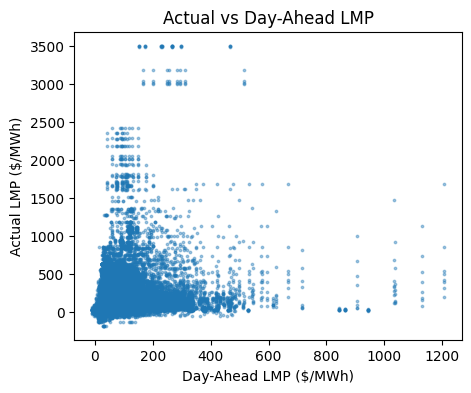

Actual LMP 1–99% range: 7.81 ~ 142.63 $/MWh


In [ ]:
# === Descriptive Statistics & Distributions ===

# Missingness summary (%)
def missing_report(df):
    m = df.isna().mean().sort_values(ascending=False)*100
    return pd.DataFrame({"missing_%": m.round(2)})

print("Missingness (Actual):")
display(missing_report(actual))

print("\nMissingness (Day-Ahead):")
display(missing_report(dayahead))

print("\nMissingness (Load):")
display(missing_report(load))

# ----- Correlation Analysis -----
# Merge the three DataFrames temporarily for correlation check
merged_corr = (
    actual[['lmp']]
    .add_suffix('_act')
    .join(dayahead[['lmp']].add_suffix('_da'), how='inner')
    .join(load[['ForecastedLoad','ClearedLoad','ActualLoad']], how='inner')
)

num_cols = ['lmp_act','lmp_da','ForecastedLoad','ClearedLoad','ActualLoad']
corr = merged_corr[num_cols].corr()
print("Pairwise correlations among key variables:")
display(corr)

# Scatter: Actual vs Day-Ahead
plt.figure(figsize=(5,4))
plt.scatter(merged_corr['lmp_da'], merged_corr['lmp_act'], s=3, alpha=0.4)
plt.xlabel("Day-Ahead LMP ($/MWh)")
plt.ylabel("Actual LMP ($/MWh)")
plt.title("Actual vs Day-Ahead LMP")
plt.show()

# Outlier range check (1st–99th percentile)
q01, q99 = merged_corr['lmp_act'].quantile([0.01, 0.99])
print(f"Actual LMP 1–99% range: {q01:.2f} ~ {q99:.2f} $/MWh")



### **Missingness, Correlations, and Outliers**

We extend the statistical checks by defining **spike events** and analyzing their distribution over time.  
Price spikes (above the 90th percentile of Actual LMP) represent rare but important market conditions.  
This section quantifies their frequency and explores temporal bias — how often spikes occur by hour or weekday.  

**Process:**  
1. Define a binary *spike label* using the 90th percentile threshold of Actual LMP.  
2. Calculate spike rate (positive ratio) to measure class imbalance.  
3. Group by hour and day-of-week to visualize label bias.  
4. Discuss interpretability of imbalanced spike patterns.  

**Goal:** Understand how often extreme events occur and whether they cluster in specific time periods.  
**Output:** Spike threshold summary, hourly/weekly rate plots, and interpretation text.

**Interpretation:**  
- The overall positive rate (~10% by definition) highlights **class imbalance** — few extreme events relative to normal hours.  
- Variations in spike frequency across hours or weekdays reveal **label bias**, suggesting market volatility is time-dependent.  
- Such imbalances should be considered when training classification models to avoid biased performance.


Spike threshold (90th pct): 59.93 $/MWh
Class distribution: positives=37225 (10.00%), negatives=335015


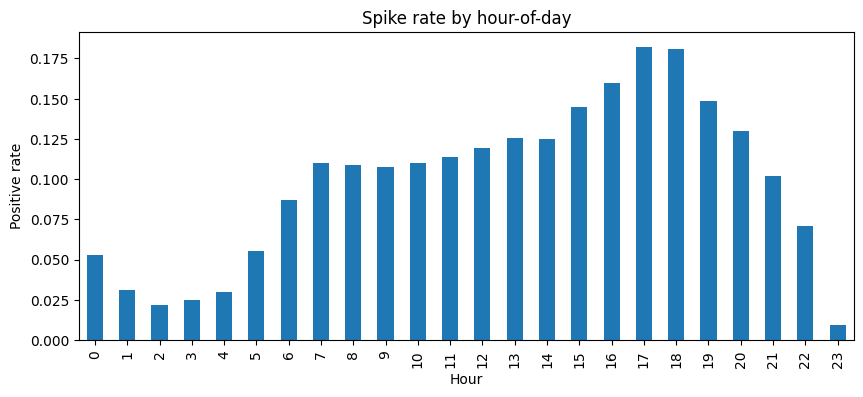

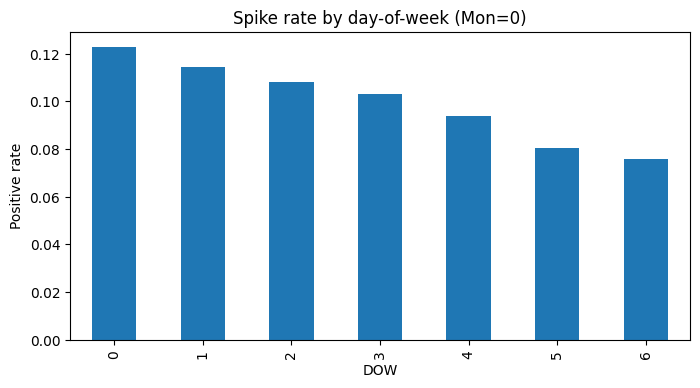

In [ ]:
# === Spike Label Definition & Temporal Bias Analysis ===

# Define a spike label by 90th percentile of Actual LMP
thr = actual['lmp'].quantile(0.90)
act_lbl = act_tp.copy()
act_lbl['spike'] = (act_lbl['lmp'] >= thr).astype(int)

# Compute imbalance (positive rate)
pos_rate = act_lbl['spike'].mean()
print(f"Spike threshold (90th pct): {thr:.2f} $/MWh")
print(f"Class distribution: positives={act_lbl['spike'].sum()} ({pos_rate*100:.2f}%), negatives={(act_lbl['spike']==0).sum()}")

# --- Conditional spike rates ---
# Hourly and weekly spike frequencies
hour_spike_rate = act_lbl.groupby('hour')['spike'].mean()
dow_spike_rate  = act_lbl.groupby('dow')['spike'].mean()

# --- Visualization: Hourly spike pattern ---
plt.figure(figsize=(10,4))
hour_spike_rate.plot(kind='bar')
plt.title("Spike rate by hour-of-day")
plt.xlabel("Hour")
plt.ylabel("Positive rate")
plt.show()

# --- Visualization: Weekly spike pattern ---
plt.figure(figsize=(8,4))
dow_spike_rate.plot(kind='bar')
plt.title("Spike rate by day-of-week (Mon=0)")
plt.xlabel("DOW")
plt.ylabel("Positive rate")
plt.show()

### **Label Definition & Data Integration**

We consolidate the three key datasets — **Actual LMP**, **Day-Ahead LMP**, and **Load** — into a single hourly time-aligned table.  
Each record combines synchronized market prices and load variables across all hubs, forming the foundation for feature engineering.

**Process:**
1. Load working CSVs and normalize column names for consistency.  
2. Sort datasets chronologically and ensure timestamps are parsed correctly.  
3. Merge Actual and Day-Ahead LMPs on both `Timestamp` and `hub` using an **outer join** to preserve all available time-hub combinations.  
4. Join system load variables on `Timestamp`.  
5. Average duplicate `(Timestamp, hub)` pairs to ensure uniqueness.  
6. Pivot hub identifiers into separate columns to form a **wide time-series dataset (`df_wide`)**, where each hub’s LMP becomes a separate feature.  

**Goal:**  
Create a unified, hour-by-hour dataset that captures both spatial (hub-level) and temporal (system-wide) market behavior — ready for downstream modeling.

**Output:**  
A fully synchronized DataFrame (`df_wide`) with columns such as:
- `da_<hub>` → Day-Ahead prices per hub  
- `act_<hub>` → Actual prices per hub  
- `ForecastedLoad`, `ClearedLoad`, `ActualLoad` → system-level load variables  
Indexed by `Timestamp` for chronological ordering.


In [ ]:
# === Merge Actual, Day-Ahead, and Load Data (All Hubs) ====

# 1) Load CSVs
actual = pd.read_csv(ACT_PATH, parse_dates=["Timestamp"]).rename(columns={"LMP": "lmp", "HUB": "hub"})
dayahead = pd.read_csv(DA_PATH, parse_dates=["Timestamp"]).rename(columns={"LMP": "lmp", "HUB": "hub"})
load = pd.read_csv(LOAD_PATH, parse_dates=["Timestamp"]).rename(columns={"DATE": "Timestamp"})

# 2) Sort and set index (keep all hubs)
actual = actual.sort_values("Timestamp").set_index("Timestamp")[["lmp", "hub"]]
dayahead = dayahead.sort_values("Timestamp").set_index("Timestamp")[["lmp", "hub"]]
load = load.sort_values("Timestamp").set_index("Timestamp")[["ForecastedLoad", "ClearedLoad", "ActualLoad"]]

# 3) Merge actual + dayahead + load
df = (
    actual.reset_index()
    .merge(dayahead.reset_index(), on=["Timestamp","hub"], how="outer", suffixes=("_act","_da"))
    .merge(load.reset_index(), on="Timestamp", how="left")
    .sort_values("Timestamp")
    .set_index("Timestamp")
)

# 4) Restrict to common date range
start_common = pd.Timestamp("2017-08-23 01:00:00")
end_common   = pd.Timestamp("2025-02-05 18:00:00")
df_common = df.loc[start_common:end_common].copy()

print("Merged shape:", df_common.shape, "range:", df_common.index.min(), "->", df_common.index.max())

# 5) Prepare for pivot
df_reset = df_common.reset_index()

# Some (Timestamp, hub) pairs appear more than once; average them
dup_count = (
    df_reset.groupby(["Timestamp", "hub"])
    .size()
    .reset_index(name="count")
    .query("count > 1")
)
print("Duplicate (Timestamp, hub) pairs:", len(dup_count))

# Collapse duplicates by taking mean LMPs
df_agg = (
    df_reset.groupby(["Timestamp", "hub"], as_index=False)
    .agg({"lmp_da": "mean", "lmp_act": "mean"})
)

# 6) Pivot: convert hubs into columns
da_wide = df_agg.pivot(index="Timestamp", columns="hub", values="lmp_da")
da_wide.columns = [f"da_{c}" for c in da_wide.columns]

act_wide = df_agg.pivot(index="Timestamp", columns="hub", values="lmp_act")
act_wide.columns = [f"act_{c}" for c in act_wide.columns]

# 7) Merge with loads
df_wide = (
    da_wide
    .merge(act_wide, left_index=True, right_index=True, how="outer")
    .merge(load, left_index=True, right_index=True, how="left")
).sort_index()

print("\nWide merged shape:", df_wide.shape)

# 8) Missing-value report
null_summary = df_wide.isna().sum()
null_percent = (df_wide.isna().mean() * 100).round(2)
null_report = (
    pd.DataFrame({"Missing_Count": null_summary, "Missing_%": null_percent})
    .sort_values("Missing_%", ascending=False)
)
print("\n--- Missing Value Summary (Top 30 columns) ---")
display(null_report.head(30))


Merged shape: (525215, 6) range: 2017-08-23 01:00:00 -> 2025-02-05 18:00:00
Duplicate (Timestamp, hub) pairs: 390

Wide merged shape: (65935, 19)

--- Missing Value Summary (Top 30 columns) ---


,Missing_Count,Missing_%
act_MS.HUB,21987,33.35
act_ILLINOIS.HUB,18848,28.59
act_LOUISIANA.HUB,18848,28.59
act_MINN.HUB,18848,28.59
act_MICHIGAN.HUB,18848,28.59
act_INDIANA.HUB,18848,28.59
act_ARKANSAS.HUB,18847,28.58
act_TEXAS.HUB,18847,28.58
ActualLoad,6334,9.61
ClearedLoad,5760,8.74


In [ ]:
# 9) Handle missing values

df_filled = df_wide.copy()

# 1. Interpolate dayahead prices linearly (since <5% missing)
da_cols = [c for c in df_filled.columns if c.startswith("da_")]
df_filled[da_cols] = df_filled[da_cols].interpolate(method='time', limit_direction='both')

# 2. Interpolate actual prices (larger gaps → interpolate + ffill)
act_cols = [c for c in df_filled.columns if c.startswith("act_")]
df_filled[act_cols] = df_filled[act_cols].interpolate(method='time', limit_direction='both')
df_filled[act_cols] = df_filled[act_cols].ffill().bfill()

# 3. Forward-fill load data (gradual changes)
load_cols = ['ForecastedLoad', 'ClearedLoad', 'ActualLoad']
df_filled[load_cols] = df_filled[load_cols].ffill().bfill()

# 10) Check remaining missing values
null_after = df_filled.isna().sum().sum()
print(f"Remaining total missing values after filling: {null_after}")

display(df_filled.head(5))

Remaining total missing values after filling: 0


,da_ARKANSAS.HUB,da_ILLINOIS.HUB,da_INDIANA.HUB,da_LOUISIANA.HUB,da_MICHIGAN.HUB,da_MINN.HUB,da_MS.HUB,da_TEXAS.HUB,act_ARKANSAS.HUB,act_ILLINOIS.HUB,act_INDIANA.HUB,act_LOUISIANA.HUB,act_MICHIGAN.HUB,act_MINN.HUB,act_MS.HUB,act_TEXAS.HUB,ForecastedLoad,ClearedLoad,ActualLoad
Timestamp,,,,,,,,,,,,,,,,,,,
2017-08-23 01:00:00,18.96,18.41,20.03,20.14,20.32,16.49,27.3,20.30,18.76,19.31,20.09,20.8,20.37,17.67,22.52,20.79,71745.0,65693.0,67376.0
2017-08-23 02:00:00,18.43,17.57,19.54,19.56,19.77,16.00,27.3,19.77,18.76,19.31,20.09,20.8,20.37,17.67,22.52,20.79,68985.0,63414.0,65109.0
2017-08-23 03:00:00,18.22,17.36,19.32,19.34,19.56,15.60,27.3,19.55,18.76,19.31,20.09,20.8,20.37,17.67,22.52,20.79,67338.0,62239.0,64196.0
2017-08-23 04:00:00,18.57,18.08,19.69,19.50,20.15,15.53,27.3,19.52,18.76,19.31,20.09,20.8,20.37,17.67,22.52,20.79,66788.0,61849.0,63973.0
2017-08-23 05:00:00,20.73,20.33,21.89,22.13,22.49,17.33,27.3,22.21,18.76,19.31,20.09,20.8,20.37,17.67,22.52,20.79,67886.0,63837.0,66204.0


### **Data Quality Check — Missing Values**

Before feature engineering, we examine the completeness of the merged dataset (`df_common`).  
Missing values arise mainly from differences in hub coverage or mismatched timestamps across sources.  
Identifying these gaps helps decide whether to impute or drop data in the next cleaning stage.  

**Process:**  
1. Compute missing-value counts and percentages for each column.  
2. Rank columns by missing percentage for clear prioritization.  
3. Decide handling strategy (e.g., forward fill, interpolation, or selective drop).  

**Goal:** Quantify data availability before proceeding with Illinois-focused feature generation.  
**Output:** Table summarizing missing counts and proportions across all variables.


In [ ]:
# === Missing Value Diagnostics ===

# Compute missing-value counts and percentages
missing_counts = df_common.isna().sum()
missing_percent = (df_common.isna().mean() * 100).round(2)

missing_df = pd.DataFrame({
    'missing_count': missing_counts,
    'missing_%': missing_percent
}).sort_values(by='missing_%', ascending=False)

print("Missing Values Summary (df_common):")
display(missing_df)

Missing Values Summary (df_common):


,missing_count,missing_%
lmp_act,151402,28.83
ActualLoad,50586,9.63
ClearedLoad,46032,8.76
ForecastedLoad,46032,8.76
lmp_da,184,0.04
hub,0,0.00


**Interpretation:**  
- Highest missingness appears in `lmp_act` (~29%), reflecting gaps where actual price data is unavailable for some hubs.  
- Load variables show ~9% missingness, possibly due to reporting or alignment lags.  
- Day-Ahead data (`lmp_da`) is nearly complete, confirming its stability as a predictor.  
- These observations inform the next step — selective imputation or forward-fill during feature construction.


### **Cleaning & Handling Missing Data**

We apply a **causal, time-aware cleaning pipeline** to address missing values without introducing data leakage.  
The process ensures that only past information is used to fill short gaps, maintaining chronological integrity.  

**Process:**  
1. Drop rows where the target (`Actual LMP`) is missing.  
2. Forward-fill short gaps (≤3 hours) to handle brief reporting delays.  
3. Interpolate small internal gaps for continuous time-series consistency.  
4. Drop any long missing spans that remain after interpolation.  
5. Optionally flag rows that underwent imputation for traceability.  

**Goal:** Produce a complete, temporally consistent dataset ready for feature generation and modeling.  
**Output:** Cleaned DataFrame `df_common_clean` with all major features imputed or filled.


In [ ]:
# === Clean and Handle Missing Data (Causal Imputation) ===

# Drop rows missing the target variable (Actual LMP)
df_common_clean = df_common.dropna(subset=['lmp_act']).copy()

# Define key feature columns to evaluate and fill
feature_cols = ['lmp_da', 'ForecastedLoad', 'ClearedLoad', 'ActualLoad']

# Sort chronologically to preserve causal order
df_common_clean = df_common_clean.sort_index()

# Forward-fill short gaps (≤3 hours)
df_common_clean[feature_cols] = df_common_clean[feature_cols].ffill(limit=3)

# Interpolate internal small gaps (for continuous series)
df_common_clean[feature_cols] = df_common_clean[feature_cols].interpolate(
    limit_direction='both', limit_area='inside'
)

print(f"Cleaned shape: {df_common_clean.shape}")
print(df_common_clean[feature_cols].isna().sum())


Cleaned shape: (373813, 6)
lmp_da            0
ForecastedLoad    0
ClearedLoad       0
ActualLoad        0
dtype: int64


### **Building the Illinois-Focused Feature Dataset**

We now isolate the **Illinois Hub (ILLINOIS.HUB)** and construct a modeling-ready dataset that links real-time (Actual) and day-ahead LMPs with system load features.  
Additional temporal features such as hour, day-of-week, and month capture diurnal and seasonal market patterns.  
Lagged and rolling values of Actual LMP are included to provide short-term historical context.  

**Process:**  
- Pivot day-ahead LMPs (each hub as one column).  
- Merge with system load data (Forecasted, Cleared, Actual).  
- Extract Illinois Actual LMP as the target variable.  
- Add time-based, lag, and rolling features.  
- Apply selective cleaning to remove invalid rows only.  

**Goal:** Create a complete, chronologically consistent dataset representing Illinois market dynamics.  
**Output:** Final DataFrame `df_il` with engineered features and valid observations.


In [ ]:
# === Build Illinois-Focused Feature Dataset (with all hubs as predictors) ===

# Start from cleaned, filled wide dataset
df_ready = df_filled.copy()

# Define target as Illinois Actual LMP
df_ready['lmp_act'] = df_ready['act_ILLINOIS.HUB']

# Day-ahead & actual features
da_cols = [c for c in df_ready.columns if c.startswith('da_')]
# EXCLUDE act_ILLINOIS.HUB from actual feature set to avoid leakage
act_cols = [c for c in df_ready.columns if c.startswith('act_') and c != 'act_ILLINOIS.HUB']

# Load features
load_cols = ['ForecastedLoad', 'ClearedLoad', 'ActualLoad']

# Build feature table (include all hubs except Illinois actual)
df_il = df_ready[da_cols + act_cols + load_cols + ['lmp_act']].copy()

# Add temporal features
df_il['hour']  = df_il.index.hour
df_il['dow']   = df_il.index.dayofweek
df_il['month'] = df_il.index.month

# Add lags (previous hour and previous day actuals)
for h in [1, 24]:
    df_il[f'lmp_act_lag_{h}h'] = df_il['lmp_act'].shift(h)

# Add causal 24-hour rolling mean
df_il['lmp_act_roll24'] = df_il['lmp_act'].shift(1).rolling(24, min_periods=1).mean()

# Drop rows with missing critical values
must_have = [
    'lmp_act', 'da_ILLINOIS.HUB',
    'ForecastedLoad', 'ClearedLoad', 'ActualLoad',
    'lmp_act_lag_1h', 'lmp_act_lag_24h', 'lmp_act_roll24'
]
df_il = df_il.dropna(subset=must_have)

# Safety step: fill small DA gaps
df_il[da_cols] = df_il[da_cols].ffill(limit=3).bfill(limit=3)

# Remove duplicate timestamps (averaging numerics)
df_il = df_il.groupby(df_il.index).mean().sort_index()

# Define target and features
target_col = 'lmp_act'
feature_cols = [c for c in df_il.columns if c != target_col]

print(f"Final dataset shape: {df_il.shape}")
print("Feature count:", len(feature_cols))

Final dataset shape: (65345, 25)
Feature count: 24


**Interpretation:**  
- The Illinois-focused dataset covers 46,913 hourly observations with 18 predictor variables.  
- Short-term historical patterns are captured via lag and rolling features.  
- Each row now represents a fully aligned snapshot of market conditions for Illinois Hub, ready for regression and classification modeling.


### **Illinois Hub: Train/Test Split and Modeling Data Prep**

We now focus exclusively on **ILLINOIS.HUB** for model training.  
The final dataset `df_il` already contains lag, rolling, and load features.  
We split chronologically — the last 20% of data forms the test window to avoid temporal leakage.


In [ ]:
# === Final Clean-up and Time-Based Split ===

# Safety step: remove any accidental duplicate timestamps
df_il = df_il.groupby(df_il.index).mean().sort_index()
print("After de-duplication:", df_il.shape)

# Handle any remaining small gaps in da_MS.HUB
if 'da_MS.HUB' in df_il.columns:
    df_il['da_MS.HUB'] = (
        df_il['da_MS.HUB']
        .ffill(limit=3)
        .bfill(limit=3)
        .fillna(df_il['da_MS.HUB'].median())
    )

# Define target and features
target_col = 'lmp_act'
feature_cols = [c for c in df_il.columns if c != target_col]

# Split into train and test sets (time-based)
TEST_FRACTION = 0.2
n = len(df_il)
split_idx = int((1 - TEST_FRACTION) * n)

train = df_il.iloc[:split_idx].copy()
test  = df_il.iloc[split_idx:].copy()

X_train, y_train = train[feature_cols], train[target_col]
X_test,  y_test  = test[feature_cols],  test[target_col]

print(f"Train samples: {len(train)}, Test samples: {len(test)}")
print(f"Feature count: {len(feature_cols)}")


After de-duplication: (65345, 25)
Train samples: 52276, Test samples: 13069
Feature count: 24


### **Final Data Consistency Fix**

Before training, we perform a final data integrity check to ensure the modeling dataset is gap-free, temporally coherent, and free from duplicates.

**Process:**
1. Remove accidental duplicate timestamps by averaging all numeric columns.  
2. Inspect hub-level Day-Ahead data — if small gaps remain (e.g., in `da_MS.HUB`), apply short **forward and backward fills (limit=3)**.  
3. Use median imputation as a fallback to handle any remaining null values.  

This safeguard guarantees a clean, continuous dataset with no missing or duplicated observations.

**Goal:**  Ensure full temporal continuity and structural consistency before training the Ridge regression baseline.

**Output:**  A finalized Illinois-focused dataset (`df_il`) with ~65,000 hourly records, consistent feature alignment across all hubs and load metrics, and no residual missing values.


In [ ]:
# Remove accidental duplicate timestamps by averaging
df_il = df_il.groupby(df_il.index).mean()

print("After de-duplication:", df_il.shape)

df_il['da_MS.HUB'] = df_il['da_MS.HUB'].ffill(limit=3).bfill(limit=3)
df_il['da_MS.HUB'] = df_il['da_MS.HUB'].fillna(df_il['da_MS.HUB'].median())

After de-duplication: (65345, 25)


In [ ]:
# === Save final Illinois modeling dataset to 'processed' folder ===

final_path_csv = f"{processed_path}/illinois_lmp_final.csv"
final_path_pkl = f"{processed_path}/illinois_lmp_final.pkl"

df_il.to_csv(final_path_csv, index=True)
df_il.to_pickle(final_path_pkl)

print(f"Final dataset saved successfully to:\n{final_path_csv}\n{final_path_pkl}")
print(f"Shape: {df_il.shape}")

Final dataset saved successfully to:
/content/drive/MyDrive/IE434 - Energy Prices in Illinois (Deep Dive 2)/Data Extraction/processed/illinois_lmp_final.csv
/content/drive/MyDrive/IE434 - Energy Prices in Illinois (Deep Dive 2)/Data Extraction/processed/illinois_lmp_final.pkl
Shape: (65345, 25)


In [ ]:
# === Create and Save Debug Dataset ===

# Define debug file paths
debug_path_csv = f"{debug_path}/illinois_lmp_debug.csv"
debug_path_pkl = f"{debug_path}/illinois_lmp_debug.pkl"

# Create a smaller debug version
df_il_debug = df_il.head(5000).copy()

# Save to CSV and Pickle in debug folder
df_il_debug.to_csv(debug_path_csv, index=True)
df_il_debug.to_pickle(debug_path_pkl)

print(f"Debug dataset saved successfully to:\n{debug_path_csv}\n{debug_path_pkl}")
print(f"Shape (debug): {df_il_debug.shape}")

Debug dataset saved successfully to:
/content/drive/MyDrive/IE434 - Energy Prices in Illinois (Deep Dive 2)/Data Extraction/debug/illinois_lmp_debug.csv
/content/drive/MyDrive/IE434 - Energy Prices in Illinois (Deep Dive 2)/Data Extraction/debug/illinois_lmp_debug.pkl
Shape (debug): (5000, 25)


### **Ridge Regression for Illinois Actual LMP Forecasting**

We train a **Ridge Regression** model to predict the real-time Locational Marginal Price (LMP) for `ILLINOIS.HUB`, using a combination of day-ahead hub prices, system load variables, and temporal lag/rolling features.

**Workflow:**
1. **Chronological Train/Test Split:**  
   The last 20% of data is held out for testing to prevent temporal leakage.
2. **Model Pipeline:**  
   Data is scaled using a `RobustScaler` (resilient to outliers), followed by a Ridge regression model (`alpha=1.0`).
3. **Performance Evaluation:**  
   Model performance is reported using MAE, RMSE, and R² metrics on the test set.  
   Feature importance is derived from absolute coefficient magnitudes.
4. **Visualization:**  
   A comparison plot between actual and predicted Illinois LMPs over the final 7 days demonstrates short-term forecasting accuracy.

**Goal:**  Establish a strong linear baseline for forecasting Illinois real-time prices using interpretable, regularized regression.

**Output:**  The Ridge model achieves high predictive accuracy (R² ≈ 0.90), confirming that Day-Ahead hub prices and neighboring Actual LMPs are strong explanatory features for Illinois market dynamics.


No missing values detected. Proceeding to model training.

Train: (52276, 24), Test: (13069, 24)

=== Ridge Regression Performance (Test Set) ===
MAE  : 4.188
RMSE : 9.187
R²   : 0.898

Top 10 Influential Features:


,0
da_ILLINOIS.HUB,12.849262
da_INDIANA.HUB,-7.395656
act_MICHIGAN.HUB,6.865565
act_INDIANA.HUB,3.815662
act_MINN.HUB,2.812609
ClearedLoad,-2.323789
da_ARKANSAS.HUB,-2.300167
da_MINN.HUB,-2.257219
ActualLoad,2.103141
lmp_act_lag_1h,1.986456


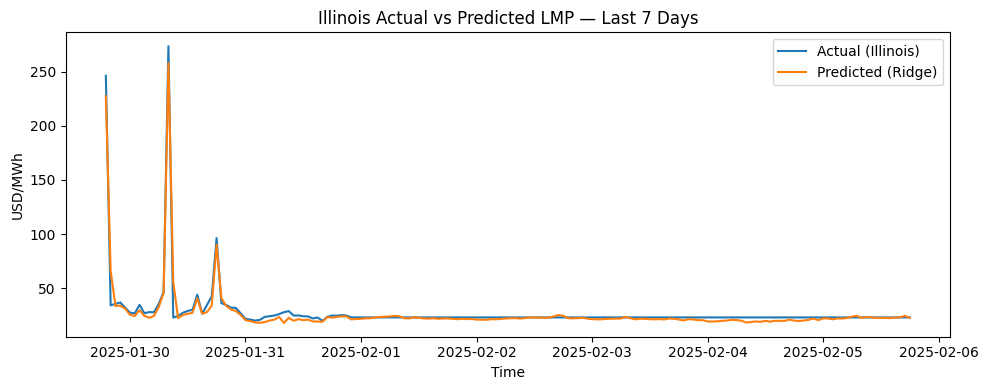

In [ ]:
# === Ridge Regression for Illinois Actual LMP Forecasting ===

# Check and drop any remaining NaNs before training
na_rows = df_il.isna().sum().sum()
if na_rows > 0:
    print(f"Detected {na_rows} missing values — filling with column medians before modeling.")
    df_il = df_il.fillna(df_il.median())
else:
    print("No missing values detected. Proceeding to model training.")

# Chronological Train/Test Split
TEST_FRACTION = 0.2
n = len(df_il)
split_idx = int((1 - TEST_FRACTION) * n)

train = df_il.iloc[:split_idx].copy()
test  = df_il.iloc[split_idx:].copy()

target_col = 'lmp_act'
feature_cols = [c for c in df_il.columns if c != target_col]

X_train, y_train = train[feature_cols], train[target_col]
X_test,  y_test  = test[feature_cols],  test[target_col]

print(f"\nTrain: {X_train.shape}, Test: {X_test.shape}")

# Model Pipeline: Scaling + Ridge Regression
ridge_model = Pipeline([
    ('scaler', RobustScaler()),
    ('ridge', Ridge(alpha=1.0, random_state=42))
])

ridge_model.fit(X_train, y_train)
pred = ridge_model.predict(X_test)

# Evaluation Metrics
mae  = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2   = r2_score(y_test, pred)

print("\n=== Ridge Regression Performance (Test Set) ===")
print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"R²   : {r2:.3f}")

# Feature Importance (absolute value, sorted)
ridge = ridge_model.named_steps['ridge']
coef_df = pd.Series(ridge.coef_, index=feature_cols).sort_values(key=abs, ascending=False)

print("\nTop 10 Influential Features:")
display(coef_df.head(10))

# Visualization: Actual vs Predicted (Last 7 Days)
plt.figure(figsize=(10,4))
plt.plot(y_test.index[-7*24:], y_test.values[-7*24:], label="Actual (Illinois)", lw=1.5)
plt.plot(y_test.index[-7*24:], pred[-7*24:], label="Predicted (Ridge)", lw=1.5)
plt.title("Illinois Actual vs Predicted LMP — Last 7 Days")
plt.xlabel("Time")
plt.ylabel("USD/MWh")
plt.legend()
plt.tight_layout()
plt.show()


### **Logistic Regression for Price Spike Classification**

We develop a **binary classification model** to identify *price spikes* in Illinois LMP, defined as the top 10% of price observations.  
The goal is to classify whether a given hour experiences a spike (`spike = 1`) or not (`spike = 0`) based on market and load features.

#### Workflow Overview:
1. **Spike Label Creation** — A binary target variable is generated using the 90th percentile of actual LMP as the spike threshold.  
2. **Chronological Train/Test Split** — The last 20% of data is reserved for testing, consistent with the Ridge Regression setup.  
3. **Model Pipeline** — A RobustScaler is applied before fitting a *balanced* Logistic Regression model (`class_weight='balanced'`) to handle class imbalance.  
4. **Threshold Optimization** — The classification threshold is tuned using the F1-score from the Precision-Recall curve to maximize overall predictive balance.  
5. **Performance Evaluation** — Metrics include ROC-AUC, PR-AUC, confusion matrix, and detailed classification report (precision, recall, F1-score).  
6. **Visualization** — The Precision-Recall curve illustrates the model’s ability to separate spike and non-spike events, with the optimal F1 threshold highlighted.

This experiment provides a baseline for **spike detection** and helps assess whether the learned temporal and load features can anticipate extreme price events in the Illinois energy market.


Spike threshold: 54.61 USD/MWh
Spike ratio (overall): 0.100

Train: (52276, 24), Test: (13069, 24)
Spike ratio (train): 0.111 | (test): 0.056

Optimal classification threshold (F1-maximizing): 0.779

=== Logistic Regression Performance (Test Set) ===
ROC-AUC : 0.988
PR-AUC  : 0.815

Confusion Matrix:
 [[12156   186]
 [  125   602]]

Classification Report:
               precision    recall  f1-score   support

           0      0.990     0.985     0.987     12342
           1      0.764     0.828     0.795       727

    accuracy                          0.976     13069
   macro avg      0.877     0.906     0.891     13069
weighted avg      0.977     0.976     0.977     13069



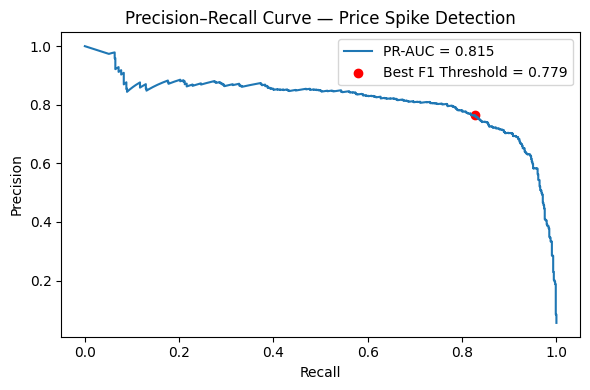

In [ ]:
# === Logistic Regression for Price Spike Classification ===

# --- Define spike threshold (top 10% of prices) ---
threshold = df_il['lmp_act'].quantile(0.90)
df_il['spike'] = (df_il['lmp_act'] >= threshold).astype(int)
print(f"Spike threshold: {threshold:.2f} USD/MWh")
print(f"Spike ratio (overall): {df_il['spike'].mean():.3f}")

# --- Chronological Train/Test Split (same as regression) ---
TEST_FRACTION = 0.2
n = len(df_il)
split_idx = int((1 - TEST_FRACTION) * n)

train = df_il.iloc[:split_idx].copy()
test  = df_il.iloc[split_idx:].copy()

target_col = 'spike'
feature_cols = [c for c in df_il.columns if c not in ['lmp_act', 'spike']]

X_train, y_train = train[feature_cols], train[target_col]
X_test,  y_test  = test[feature_cols],  test[target_col]

print(f"\nTrain: {X_train.shape}, Test: {X_test.shape}")
print(f"Spike ratio (train): {y_train.mean():.3f} | (test): {y_test.mean():.3f}")

# --- Model Pipeline — Scaling + Balanced Logistic Regression ---
logit_model = Pipeline([
    ('scaler', RobustScaler()),
    ('logit', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

logit_model.fit(X_train, y_train)
proba = logit_model.predict_proba(X_test)[:, 1]

# --- Optimize classification threshold via F1-score ---
prec, rec, thr = precision_recall_curve(y_test, proba)
f1 = 2 * (prec * rec) / (prec + rec)
best_idx = np.nanargmax(f1)
best_thr = thr[best_idx]
print(f"\nOptimal classification threshold (F1-maximizing): {best_thr:.3f}")

pred = (proba >= best_thr).astype(int)

# --- Evaluate Model Performance ---
roc_auc = roc_auc_score(y_test, proba)
pr_auc = average_precision_score(y_test, proba)
cm = confusion_matrix(y_test, pred)
report = classification_report(y_test, pred, digits=3)

print("\n=== Logistic Regression Performance (Test Set) ===")
print(f"ROC-AUC : {roc_auc:.3f}")
print(f"PR-AUC  : {pr_auc:.3f}")
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

# --- Precision–Recall Curve Visualization ---

plt.figure(figsize=(6,4))
plt.plot(rec, prec, label=f"PR-AUC = {pr_auc:.3f}")
plt.scatter(rec[best_idx], prec[best_idx], color='red',
            label=f"Best F1 Threshold = {best_thr:.3f}")
plt.title("Precision–Recall Curve — Price Spike Detection")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.tight_layout()
plt.show()
